In [1]:
import sys
print(sys.version)

3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


In [2]:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GaussianNoise, GaussianDropout

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# import numpy as np

import h5py

import pickle
import cv2
import os

import PIL
import time
import pathlib

# from IPython import display

In [4]:
print("Tensorflow version: ", tf.VERSION) # 1.13.1
print("Keras version: ", tf.keras.__version__) # 2.2.4-tf

tf.enable_eager_execution()
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.test.is_gpu_available())

# from tensorflow.python.client import device_lib
# print('List of GPUs:\n',
#       [x for x in device_lib.list_local_devices()
#        if x.device_type == "GPU" or x.device_type == "SYCL"])

Tensorflow version:  1.13.1
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  True


# SmallerVGGNet, with tf.keras and eager execution

Source:
https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

In [5]:
filename = 'year_vgg'

path_train_tfrecord = "/data/fp_train.tfrecord"
path_test_tfrecord = "/data/fp_test.tfrecord"

predict_test_only = True


In [6]:
class SmallerVGGNet_regression:
    @staticmethod
    def build(width, height, depth):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # add noise to input data
#         model.add(GaussianNoise(0.05, 
#                                 input_shape=inputShape))    
#         model.add(GaussianDropout(0.1, 
#                                   input_shape=inputShape))   
#         model.add(GaussianNoise(0.05))
            
        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
                         input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(64, name='learned_representation'))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(1))

        # return the constructed network architecture
        return model

In [7]:
path_model = "/data/" + filename + ".h5"
dir_model = os.path.dirname(path_model)

pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [8]:
# https://medium.com/@moritzkrger/speeding-up-keras-with-tfrecord-datasets-5464f9836c36

EPOCHS = 100

BUFFER_SIZE = 1024
BATCH_SIZE = 8

IMAGE_DIMS = (28, 28, 6)
# LABEL_DIM = 1

def _parse_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['norm_year']

def create_dataset(filepath):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=8)
    
    # This dataset will go on forever
    dataset = dataset.repeat()
    
    # Set the number of datapoints you want to load and shuffle 
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

train_dataset = create_dataset(path_train_tfrecord)
test_dataset =  create_dataset(path_test_tfrecord)
train_dataset

<DatasetV1Adapter shapes: ((?, 28, 28, 6), (?,)), types: (tf.float32, tf.float32)>

In [9]:
model = SmallerVGGNet_regression.build(
    width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2],
)

for images,labels in train_dataset.take(1):
    print("Logits: ", model(images[0:1]).numpy())
    
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Logits:  [[0.01911291]]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        1760      
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 32)          0         
_______________________________________________________________

In [10]:
model.compile(optimizer='RMSprop', 
              loss='mean_squared_error')

Instructions for updating:
Use tf.cast instead.


In [11]:
if not predict_test_only:
    monitor = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, verbose=1
    )

    history= model.fit(train_dataset,
                       epochs=100,
                       steps_per_epoch=39686//BATCH_SIZE,
                       validation_data=test_dataset,
                       validation_steps=10854//BATCH_SIZE,
                       callbacks=[monitor]
                      )

In [12]:
if not predict_test_only:
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    H = history
    N = len(H.history["loss"])

    plt.plot(np.arange(1, N+1), H.history["loss"], label="train_loss")
    plt.plot(np.arange(1, N+1), H.history["val_loss"], label="val_loss")

    # plt.plot(np.arange(1, N+1), H.history["acc"], label="train_acc")
    # plt.plot(np.arange(1, N+1), H.history["val_acc"], label="val_acc")
    # plt.ylim(bottom=0)

    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper left")

    plt.savefig("/data/" + filename + ".pdf")
    plt.savefig("/data/" + filename + ".png")


In [13]:
if not predict_test_only:
    with h5py.File(path_model,'w') as file:
        weight = model.get_weights()
        for i in range(len(weight)):
            file.create_dataset('weight'+str(i),data=weight[i])
    !ls -al {path_model}

In [14]:
with h5py.File(path_model,'r') as file:
    weight = []
    for i in range(len(file.keys())):
        weight.append(file['weight'+str(i)][:])
        
model.set_weights(weight)
# weight

In [15]:
def _parse_predict_function(example_proto):
    # Create a description of the features.  
    feature_description = {
        # [AREA_UNIT, AREA_ENTRANCE, AREA_LDK, AREA_BEDROOM, AREA_BALCONY, AREA_BATHROOM]
        'floorplan': tf.FixedLenFeature([28, 28, 6], tf.float32, 
                                        default_value=tf.zeros([28, 28, 6], tf.float32)),
        
        'plan_id': tf.FixedLenFeature([], tf.string, default_value=''),
        'norm_year': tf.FixedLenFeature([], tf.float32, default_value=-1.0),
        'sido': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'norm_area': tf.FixedLenFeature([], tf.float32, default_value=0.0),
        'is_area_85': tf.FixedLenFeature([], tf.int64, default_value=0),
        'is_core': tf.FixedLenFeature([], tf.int64, default_value=0),
        'num_rooms': tf.FixedLenFeature([], tf.int64, default_value=-1),
        'num_baths': tf.FixedLenFeature([], tf.int64, default_value=-1)
    }
    
    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.parse_single_example(example_proto, feature_description)
    
    return parsed_example['floorplan'], parsed_example['plan_id'], parsed_example['norm_year']

def create_predict_dataset(filepaths):
    
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepaths, compression_type="GZIP")
    
    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_predict_function, num_parallel_calls=8)

    # Set the batchsize
    dataset = dataset.batch(BATCH_SIZE)
    
    return dataset

In [16]:
if predict_test_only:
    paths_predict_tfrecord = [path_test_tfrecord]
else:
    paths_predict_tfrecord = [path_train_tfrecord, path_test_tfrecord]

In [17]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
predictions = model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

predictions = [x[0] for x in predictions]
# predictions

In [18]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

ids = []
for batch in iter:
    ids.extend(batch[1].numpy())

ids = [x.decode() for x in ids]
# ids

In [19]:
predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
iter = predict_dataset.make_one_shot_iterator()

true_year = []
for batch in iter:
    true_year.extend(batch[2].numpy())

# true_year

In [20]:
df = pd.DataFrame(zip(ids, true_year, predictions), columns=['ID', 'true_year', 'prediction'])
# df

In [21]:
df.corr()

,true_year,prediction
true_year,1.000000,0.877075
prediction,0.877075,1.000000


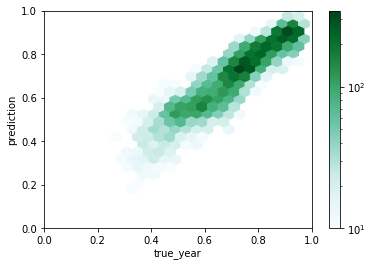

In [22]:
ax = df.plot.hexbin(x='true_year',y='prediction',
                    extent=(-0.03,1.01,-0.03,1.01), xlim=(0,1), ylim=(0,1), 
                    sharex=False, gridsize=26,
                    bins='log', mincnt=10,
                   )
ax.set_facecolor('w')
fig = ax.get_figure()

if predict_test_only: 
    dataset_tag = "_testonly"
else:
    dataset_tag = ""

fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".pdf")
fig.savefig("/data/" + filename + "_prediction" + dataset_tag + ".png")
!cp /data/{filename}* .

In [23]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

layer_name = 'learned_representation'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

predict_dataset =  create_predict_dataset(paths_predict_tfrecord)
intermediate_output = intermediate_layer_model.predict(
    predict_dataset,
    steps=60000//BATCH_SIZE
)

intermediate_output

array([[  96.88747  ,  -59.772705 ,   90.543526 , ...,  104.72804  ,
        -105.832695 ,   99.982925 ],
       [  10.06717  ,   26.563515 ,   37.86415  , ...,  -71.041534 ,
         106.86857  ,  -39.593544 ],
       [ -27.940872 ,   52.501625 ,   45.45455  , ...,  -31.74081  ,
          88.45309  ,   25.536837 ],
       ...,
       [  13.552503 ,   51.96018  ,  -43.048595 , ..., -102.48335  ,
         112.282295 ,  -93.39317  ],
       [  43.50154  ,   -4.3154297,   92.02491  , ...,    5.656111 ,
          47.82928  ,   48.503605 ],
       [ 113.0422   ,  -71.42799  ,   74.45516  , ...,  124.1257   ,
        -137.6701   ,  109.63949  ]], dtype=float32)

In [24]:
len(intermediate_output)

10854